# Twitter Sentiment Analysis using NLTK, Python for Donald Trump

In [1]:
# ref: https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading and Extracting data from .csv files

In [2]:
!wget https://raw.githubusercontent.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/master/Data/train_tweets.csv
!wget https://raw.githubusercontent.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/master/Data/test_tweets.csv

--2020-05-30 07:37:15--  https://raw.githubusercontent.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/master/Data/train_tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/plain]
Saving to: ‘train_tweets.csv.1’

train_tweets.csv.1  100%[===================>]   2.96M  9.15MB/s    in 0.3s    

2020-05-30 07:37:16 (9.15 MB/s) - ‘train_tweets.csv.1’ saved [3103165/3103165]

--2020-05-30 07:37:16--  https://raw.githubusercontent.com/MohamedAfham/Twitter-Sentiment-Analysis-Supervised-Learning/master/Data/test_tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1

In [3]:
train_tweets = pd.read_csv('./train_tweets.csv')
test_tweets = pd.read_csv('./test_tweets.csv')

In [4]:
train_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
print('train_tweets shape: {}, label 0: {}, label 1: {}'.format(train_tweets.shape, train_tweets[train_tweets['label']==0].count()['label'], train_tweets[train_tweets['label']==1].count()['label']))

train_tweets shape: (31962, 3), label 0: 29720, label 1: 2242


## Exploratory Data Analysis

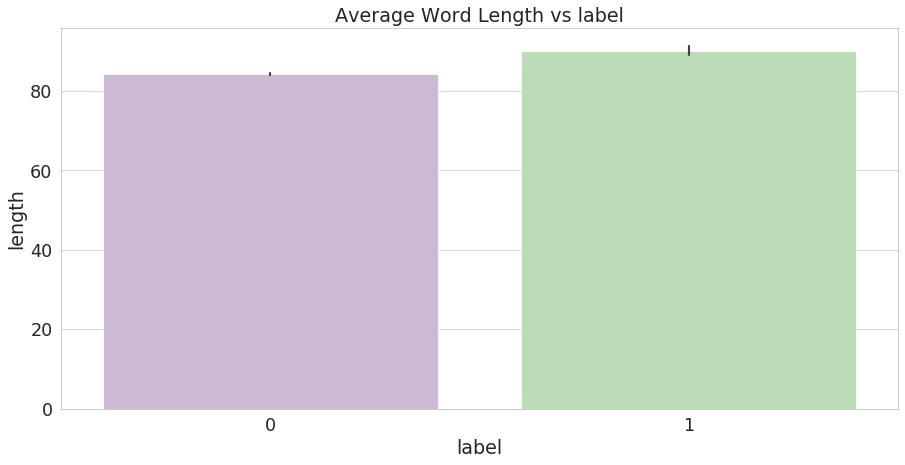

In [6]:
# Average Word Length vs label
sns.set_style('whitegrid')
sns.set_context(context='paper', font_scale=2, rc=None)

train_tweets = train_tweets[['label','tweet']]
test = test_tweets['tweet']
train_tweets['length'] = train_tweets['tweet'].apply(len)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Average Word Length vs label')
fig = sns.barplot('label', 'length', data = train_tweets, palette='PRGn')

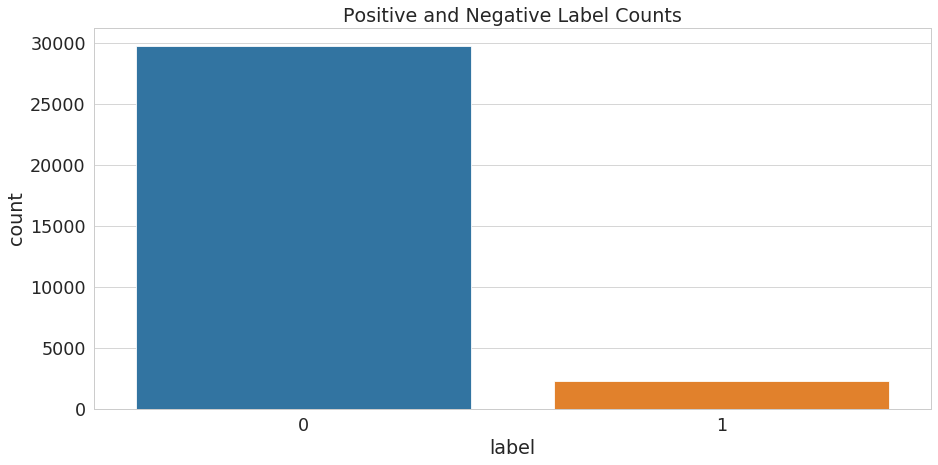

In [7]:
# Positive and Negative Label Counts
fig2 = plt.figure(figsize=(15, 7))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.set_title('Positive and Negative Label Counts')
fig2 = sns.countplot(x='label', data = train_tweets)

## Feature engineering

In [8]:
import nltk

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [9]:
def preprocessing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [10]:
print(train_tweets['tweet'].iloc[10])

 â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex


In [11]:
print(preprocessing(train_tweets['tweet'].iloc[10]))

['ireland', 'consumer', 'price', 'index', 'mom', 'climb', 'previous', 'may', 'blog', 'silver', 'gold', 'forex']


## Data preprocessing and oversample negative tweets

In [12]:
train_tweets['tweet_list'] = train_tweets['tweet'].apply(preprocessing)
test_tweets['tweet_list'] = test_tweets['tweet'].apply(preprocessing)
train_tweets.head()

,label,tweet,length,tweet_list
0,0,@user when a father is dysfunctional and is s...,102,"[father, dysfunctional, selfish, drag, kid, dy..."
1,0,@user @user thanks for #lyft credit i can't us...,122,"[thank, lyft, credit, ca, use, cause, offer, w..."
2,0,bihday your majesty,21,"[bihday, majesty]"
3,0,#model i love u take with u all the time in ...,86,"[model, love, u, take, u, time]"
4,0,factsguide: society now #motivation,39,"[factsguide, society, motivation]"


In [13]:
"""
min_df=2, discard words appearing in less than 2 documents
max_df=0.9, discard words appering in more than 90% of the documents
sublinear_tf=True, use sublinear weighting
use_idf=True, enable IDF
"""
vec = TfidfVectorizer(
    analyzer=preprocessing,
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    use_idf=True
)

train_vec = vec.fit_transform(train_tweets['tweet'])
test_vec = vec.transform(test_tweets['tweet'])

In [14]:
vec.get_feature_names()
print(len(vec.get_feature_names()))

12044


In [15]:
X = train_vec
y = train_tweets['label']
test = test_vec

In [16]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = sm.fit_sample(X, y)
print('label balance:\n{}'.format(y_resampled.value_counts()))

label balance:
1    29720
0    29720
Name: label, dtype: int64


## Model selection and train a model

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (39824, 12044)
X_test shape: (19616, 12044)
y_train shape: (39824,)
y_test shape: (19616,)


In [18]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
clf_svc = svm.LinearSVC(random_state=42)
clf_rfc = RandomForestClassifier(random_state=42)
clf_gbc = GradientBoostingClassifier(random_state=42)
clf_names = ['SVM', 'RandomForest', 'GradientBoosting']
clf_types = [clf_svc, clf_rfc, clf_gbc]

for (i, clf) in enumerate(clf_types):
    clf.fit(X_train, y_train.values.ravel())
    print('Result of {}\n'.format(clf_names[i]))
    predictions = clf.predict(X_test)
    print(classification_report(predictions, y_test))
    print('\n')
    print('Confusion matrix: \n', confusion_matrix(predictions, y_test))
    print('Accuracy score: ', accuracy_score(predictions, y_test))
    print('\n\n\n')

Result of SVM

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9051
           1       0.99      0.93      0.96     10565

    accuracy                           0.96     19616
   macro avg       0.96      0.96      0.96     19616
weighted avg       0.96      0.96      0.96     19616



Confusion matrix: 
 [[8972   79]
 [ 779 9786]]
Accuracy score:  0.9562601957585645




Result of RandomForest

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9463
           1       0.99      0.96      0.97     10153

    accuracy                           0.97     19616
   macro avg       0.97      0.97      0.97     19616
weighted avg       0.97      0.97      0.97     19616



Confusion matrix: 
 [[9352  111]
 [ 399 9754]]
Accuracy score:  0.9740008156606852




Result of GradientBoosting

              precision    recall  f1-score   support

           0       0.95      0.72      0.82   

## Test the generated model

In [19]:
# https://twitter.com/realDonaldTrump/status/1266231100172615680
tweet1 = 'I can\'t stand back & watch this happen to a great American City, Minneapolis. A total lack of leadership. Either the very weak Radical Left Mayor, Jacob Frey, get his act together and bring the City under control, or I will send in the National Guard & get the job done right.....'
# https://twitter.com/realDonaldTrump/status/1266047584038256640
tweet2 = 'So ridiculous to see Twitter trying to make the case that Mail-In Ballots are not subject to FRAUD. How stupid, there are examples, & cases, all over the place. Our election process will become badly tainted & a laughingstock all over the World. Tell that to your hater'
preprocess_tweet1 = preprocessing(tweet1)
print(preprocess_tweet1)
preprocess_tweet2 = preprocessing(tweet2)
print(preprocess_tweet2)

['ca', 'stand', 'back', 'watch', 'happen', 'great', 'American', 'City', 'Minneapolis', 'total', 'lack', 'leadership', 'Either', 'weak', 'Radical', 'Left', 'Mayor', 'Jacob', 'Frey', 'get', 'act', 'together', 'bring', 'City', 'control', 'send', 'National', 'Guard', 'get', 'job', 'do', 'right']
['ridiculous', 'see', 'Twitter', 'try', 'make', 'case', 'Ballots', 'subject', 'FRAUD', 'stupid', 'examples', 'case', 'place', 'election', 'process', 'become', 'badly', 'taint', 'laughingstock', 'World', 'Tell', 'hater']


In [20]:
# vectorize the tweet
tweet_pd_1 = pd.Series([tweet1])
tweet_pd_2 = pd.Series([tweet2])
tweet_vec_1 = vec.transform(tweet_pd_1)
tweet_vec_2 = vec.transform(tweet_pd_2)

In [21]:
# predict a label for the tweet1
tweet_prediction_1 = clf_rfc.predict(tweet_vec_1)
print('{} has been predicted for the tweet {}'.format(tweet_prediction_1, tweet1))

[0] has been predicted for the tweet I can't stand back & watch this happen to a great American City, Minneapolis. A total lack of leadership. Either the very weak Radical Left Mayor, Jacob Frey, get his act together and bring the City under control, or I will send in the National Guard & get the job done right.....


In [22]:
# predict a label for the tweet2
tweet_prediction_2 = clf_rfc.predict(tweet_vec_2)
print('{} has been predicted for the tweet {}'.format(tweet_prediction_2, tweet2))

[1] has been predicted for the tweet So ridiculous to see Twitter trying to make the case that Mail-In Ballots are not subject to FRAUD. How stupid, there are examples, & cases, all over the place. Our election process will become badly tainted & a laughingstock all over the World. Tell that to your hater
